In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, drop_rate=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.drop_rate = drop_rate
        self.shortcut = None
        if in_planes != out_planes or stride != 1:
            self.shortcut = nn.Conv2d(in_planes, out_planes, 1, stride, 0, bias=False)

    def forward(self, x):
        out = self.relu(self.bn1(x))
        if self.shortcut is not None:
            shortcut = self.shortcut(out)
        else:
            shortcut = x
        out = self.conv1(out)
        out = self.relu(self.bn2(out))
        out = self.conv2(out)
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return out + shortcut


class NetworkBlock(nn.Module):
    def __init__(self, num_layers, in_planes, out_planes, block, stride, drop_rate):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(
                block(in_planes if i == 0 else out_planes,
                      out_planes,
                      stride if i == 0 else 1,
                      drop_rate)
            )
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=100, drop_rate=0.3):
        super().__init__()
        assert (depth - 4) % 6 == 0
        n = (depth - 4) // 6
        k = widen_factor
        n_channels = [16, 16 * k, 32 * k, 64 * k]

        self.conv1 = nn.Conv2d(3, n_channels[0], 3, 1, 1, bias=False)
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], BasicBlock, 1, drop_rate)
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], BasicBlock, 2, drop_rate)
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], BasicBlock, 2, drop_rate)
        self.bn = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(n_channels[3], num_classes)

        # --- He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


train_transforms = A.Compose([
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),
    A.RandomCrop(32, 32, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.OneOf([
        A.CoarseDropout(
            max_holes=1,
            max_height=16, max_width=16,
            min_height=8,  min_width=8,
            fill_value=tuple([int(x * 255) for x in [0.5071, 0.4867, 0.4408]]),
            p=1.0
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    ], p=0.3),
    A.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
    ToTensorV2(),
])

test_transforms = A.Compose([
    A.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
    ToTensorV2(),
])


class AlbumentationsTransform:
    def __init__(self, aug):
        self.aug = aug
    def __call__(self, img):
        img = np.array(img)
        augmented = self.aug(image=img)
        return augmented["image"]

g = torch.Generator()
g.manual_seed(42)

train_dataset = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=AlbumentationsTransform(train_transforms)
)

test_dataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=AlbumentationsTransform(test_transforms)
)

# ---- 4️⃣ DataLoaders ----
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    worker_init_fn=lambda _: np.random.seed(42),
    generator=g
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,

)

/tmp/ipython-input-3918796701.py:11: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=0, p=1.0),
/tmp/ipython-input-3918796701.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipython-input-3918796701.py:23: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


In [ ]:
import numpy as np
import torch

# --- Mixup & CutMix helper functions ---
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return x1, y1, x2, y2


def apply_mixup_cutmix(images, labels, alpha=1.0, cutmix_prob=0.5, use_cutmix=True, use_mixup=True):
    r = np.random.rand(1)
    if alpha <= 0 or (not use_cutmix and not use_mixup):
        return images, labels, 1.0, None, None

    if use_cutmix and r < cutmix_prob:
        # --- CutMix ---
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(images.size(0)).to(images.device)
        target_a = labels
        target_b = labels[rand_index]
        x1, y1, x2, y2 = rand_bbox(images.size(), lam)
        images[:, :, y1:y2, x1:x2] = images[rand_index, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (images.size(-1) * images.size(-2)))
        return images, target_a, target_b, lam, "cutmix"

    elif use_mixup:
        # --- Mixup ---
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(images.size(0)).to(images.device)
        mixed_images = lam * images + (1 - lam) * images[rand_index, :]
        target_a = labels
        target_b = labels[rand_index]
        return mixed_images, target_a, target_b, lam, "mixup"

    else:
        return images, labels, 1.0, None, None


In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

def train_model(model, train_loader, test_loader, device,
                epochs=50, max_lr=0.3, weight_decay=5e-4,
                label_smoothing=0.1, use_mixup_cutmix=True,
                alpha=1.0, cutmix_prob=0.2):

    # Initialize
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=weight_decay)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1000,
        anneal_strategy='cos'
    )

    # Metrics tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'learning_rates': []
    }

    best_acc = 0.0

    # Training loop
    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"{'='*60}")

        # ========== TRAINING PHASE ==========
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)

            if use_mixup_cutmix:
                images, targets_a, targets_b, lam, aug_type = apply_mixup_cutmix(
                    images, labels, alpha=alpha, cutmix_prob=cutmix_prob
                )
            else:
                targets_a, targets_b, lam, aug_type = labels, None, 1.0, None

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            if aug_type in ["mixup", "cutmix"]:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * images.size(0)

            # ===== ✅ FIXED ACCURACY SECTION =====
            _, predicted = outputs.max(1)
            train_total += labels.size(0)

            if aug_type in ["mixup", "cutmix"]:
                # weighted accuracy for mixed labels (mathematically correct)
                correct_a = predicted.eq(targets_a).sum().item()
                correct_b = predicted.eq(targets_b).sum().item()
                train_correct += lam * correct_a + (1 - lam) * correct_b
            else:
                train_correct += predicted.eq(labels).sum().item()


            raw_correct = predicted.eq(labels).sum().item()
            raw_train_acc = 100. * raw_correct / train_total

            progress.set_postfix({
                'Loss': f"{loss.item():.3f}",
                'LR': f"{scheduler.get_last_lr()[0]:.6f}",
                'Aug': aug_type if aug_type else 'none',
                'Acc': f"{100. * train_correct / train_total:.2f}%",
                'Raw': f"{raw_train_acc:.2f}%"
            })

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / train_total

        # ========== EVALUATION PHASE ==========
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            eval_progress = tqdm(test_loader, desc="Evaluating", leave=False)
            for images, labels in eval_progress:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

                eval_progress.set_postfix({
                    'Loss': f"{loss.item():.3f}",
                    'Acc': f"{100. * test_correct / test_total:.2f}%"
                })

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * test_correct / test_total


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['learning_rates'].append(scheduler.get_last_lr()[0])



        print(f"Train Loss: {train_loss:.4f} | Ttrain Acc: {train_acc:.2f}%)")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),  # <-- ADD THIS LINE
                'test_acc': test_acc,
            }, 'best_model.pth')
            print(f"✓ Best model saved! (Test Acc: {test_acc:.2f}%)")

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"{'='*60}\n")

    return history, model



In [ ]:
def plot_training_history(history, save_path='training_plots.png'):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs, history['test_acc'], 'r-', label='Test Acc', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')

    # Test accuracy zoomed
    axes[1, 1].plot(epochs, history['test_acc'], 'r-', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Test Accuracy (%)', fontsize=12)
    axes[1, 1].set_title('Test Accuracy Progress', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=max(history['test_acc']), color='r', linestyle='--',
                       alpha=0.5, label=f"Best: {max(history['test_acc']):.2f}%")
    axes[1, 1].legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training plots saved to {save_path}")

In [ ]:
model = WideResNet(depth=28, widen_factor=10, num_classes=100).to(device)

In [ ]:
history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=200,
    max_lr=0.3,
    weight_decay=5e-4,
    label_smoothing=0.1,
    use_mixup_cutmix=True
)


Epoch [1/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.5060 | Ttrain Acc: 2.58%)
Test Loss:  4.2552 | Test Acc:  5.35%
Learning Rate: 0.012197
✓ Best model saved! (Test Acc: 5.35%)

Epoch [2/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.3305 | Ttrain Acc: 5.61%)
Test Loss:  4.1598 | Test Acc:  8.48%
Learning Rate: 0.012789
✓ Best model saved! (Test Acc: 8.48%)

Epoch [3/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.2272 | Ttrain Acc: 7.69%)
Test Loss:  4.0014 | Test Acc:  11.11%
Learning Rate: 0.013773
✓ Best model saved! (Test Acc: 11.11%)

Epoch [4/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.1514 | Ttrain Acc: 9.20%)
Test Loss:  3.8993 | Test Acc:  12.00%
Learning Rate: 0.015147
✓ Best model saved! (Test Acc: 12.00%)

Epoch [5/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.0797 | Ttrain Acc: 10.90%)
Test Loss:  3.6752 | Test Acc:  17.24%
Learning Rate: 0.016908
✓ Best model saved! (Test Acc: 17.24%)

Epoch [6/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 4.0293 | Ttrain Acc: 12.37%)
Test Loss:  3.5244 | Test Acc:  20.64%
Learning Rate: 0.019049
✓ Best model saved! (Test Acc: 20.64%)

Epoch [7/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.9428 | Ttrain Acc: 14.29%)
Test Loss:  3.4121 | Test Acc:  23.62%
Learning Rate: 0.021566
✓ Best model saved! (Test Acc: 23.62%)

Epoch [8/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.8583 | Ttrain Acc: 16.55%)
Test Loss:  3.3289 | Test Acc:  26.43%
Learning Rate: 0.024452
✓ Best model saved! (Test Acc: 26.43%)

Epoch [9/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.8031 | Ttrain Acc: 18.19%)
Test Loss:  3.3169 | Test Acc:  26.45%
Learning Rate: 0.027698
✓ Best model saved! (Test Acc: 26.45%)

Epoch [10/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.7412 | Ttrain Acc: 19.57%)
Test Loss:  3.1737 | Test Acc:  29.01%
Learning Rate: 0.031296
✓ Best model saved! (Test Acc: 29.01%)

Epoch [11/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.6333 | Ttrain Acc: 22.16%)
Test Loss:  3.2372 | Test Acc:  29.78%
Learning Rate: 0.035235
✓ Best model saved! (Test Acc: 29.78%)

Epoch [12/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.6361 | Ttrain Acc: 22.33%)
Test Loss:  3.0478 | Test Acc:  32.84%
Learning Rate: 0.039506
✓ Best model saved! (Test Acc: 32.84%)

Epoch [13/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.6053 | Ttrain Acc: 23.53%)
Test Loss:  2.8150 | Test Acc:  38.36%
Learning Rate: 0.044096
✓ Best model saved! (Test Acc: 38.36%)

Epoch [14/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.5610 | Ttrain Acc: 24.53%)
Test Loss:  3.0112 | Test Acc:  33.69%
Learning Rate: 0.048993

Epoch [15/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.4924 | Ttrain Acc: 26.25%)
Test Loss:  2.7500 | Test Acc:  39.37%
Learning Rate: 0.054183
✓ Best model saved! (Test Acc: 39.37%)

Epoch [16/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.4964 | Ttrain Acc: 26.36%)
Test Loss:  2.8117 | Test Acc:  38.74%
Learning Rate: 0.059653

Epoch [17/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.5071 | Ttrain Acc: 26.53%)
Test Loss:  2.8430 | Test Acc:  37.38%
Learning Rate: 0.065386

Epoch [18/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.4336 | Ttrain Acc: 28.04%)
Test Loss:  2.7281 | Test Acc:  40.93%
Learning Rate: 0.071368
✓ Best model saved! (Test Acc: 40.93%)

Epoch [19/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.4233 | Ttrain Acc: 28.50%)
Test Loss:  2.6836 | Test Acc:  41.79%
Learning Rate: 0.077582
✓ Best model saved! (Test Acc: 41.79%)

Epoch [20/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3872 | Ttrain Acc: 29.58%)
Test Loss:  2.6044 | Test Acc:  44.44%
Learning Rate: 0.084011
✓ Best model saved! (Test Acc: 44.44%)

Epoch [21/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3979 | Ttrain Acc: 29.40%)
Test Loss:  2.7795 | Test Acc:  39.16%
Learning Rate: 0.090637

Epoch [22/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3505 | Ttrain Acc: 31.02%)
Test Loss:  2.5259 | Test Acc:  45.84%
Learning Rate: 0.097443
✓ Best model saved! (Test Acc: 45.84%)

Epoch [23/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3407 | Ttrain Acc: 31.20%)
Test Loss:  2.5639 | Test Acc:  44.94%
Learning Rate: 0.104409

Epoch [24/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3771 | Ttrain Acc: 30.12%)
Test Loss:  2.8968 | Test Acc:  37.89%
Learning Rate: 0.111516

Epoch [25/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3402 | Ttrain Acc: 31.09%)
Test Loss:  2.5886 | Test Acc:  45.39%
Learning Rate: 0.118746

Epoch [26/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3459 | Ttrain Acc: 31.05%)
Test Loss:  2.4376 | Test Acc:  48.72%
Learning Rate: 0.126077
✓ Best model saved! (Test Acc: 48.72%)

Epoch [27/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2898 | Ttrain Acc: 32.38%)
Test Loss:  2.5091 | Test Acc:  46.45%
Learning Rate: 0.133491

Epoch [28/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3367 | Ttrain Acc: 31.36%)
Test Loss:  2.4998 | Test Acc:  47.16%
Learning Rate: 0.140966

Epoch [29/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2667 | Ttrain Acc: 33.49%)
Test Loss:  2.4982 | Test Acc:  47.37%
Learning Rate: 0.148482

Epoch [30/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2892 | Ttrain Acc: 32.87%)
Test Loss:  2.5860 | Test Acc:  46.43%
Learning Rate: 0.156019

Epoch [31/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2742 | Ttrain Acc: 33.37%)
Test Loss:  2.7025 | Test Acc:  42.87%
Learning Rate: 0.163556

Epoch [32/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3200 | Ttrain Acc: 32.02%)
Test Loss:  2.5530 | Test Acc:  45.13%
Learning Rate: 0.171073

Epoch [33/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3485 | Ttrain Acc: 31.57%)
Test Loss:  2.5283 | Test Acc:  46.29%
Learning Rate: 0.178547

Epoch [34/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.3076 | Ttrain Acc: 31.98%)
Test Loss:  2.4971 | Test Acc:  47.74%
Learning Rate: 0.185961

Epoch [35/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2626 | Ttrain Acc: 33.72%)
Test Loss:  2.3705 | Test Acc:  50.72%
Learning Rate: 0.193292
✓ Best model saved! (Test Acc: 50.72%)

Epoch [36/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2859 | Ttrain Acc: 33.18%)
Test Loss:  2.6796 | Test Acc:  42.62%
Learning Rate: 0.200520

Epoch [37/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2264 | Ttrain Acc: 34.18%)
Test Loss:  2.6007 | Test Acc:  46.91%
Learning Rate: 0.207627

Epoch [38/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1945 | Ttrain Acc: 35.18%)
Test Loss:  2.5307 | Test Acc:  47.72%
Learning Rate: 0.214592

Epoch [39/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2418 | Ttrain Acc: 34.19%)
Test Loss:  2.3898 | Test Acc:  49.82%
Learning Rate: 0.221397

Epoch [40/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2290 | Ttrain Acc: 34.33%)
Test Loss:  2.6087 | Test Acc:  45.01%
Learning Rate: 0.228022

Epoch [41/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2994 | Ttrain Acc: 32.44%)
Test Loss:  2.5949 | Test Acc:  46.34%
Learning Rate: 0.234450

Epoch [42/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2559 | Ttrain Acc: 33.61%)
Test Loss:  2.4772 | Test Acc:  48.41%
Learning Rate: 0.240663

Epoch [43/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2373 | Ttrain Acc: 34.27%)
Test Loss:  2.5712 | Test Acc:  45.96%
Learning Rate: 0.246644

Epoch [44/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2823 | Ttrain Acc: 33.09%)
Test Loss:  2.6130 | Test Acc:  45.78%
Learning Rate: 0.252376

Epoch [45/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1988 | Ttrain Acc: 35.11%)
Test Loss:  3.1631 | Test Acc:  38.48%
Learning Rate: 0.257844

Epoch [46/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2517 | Ttrain Acc: 34.06%)
Test Loss:  2.6083 | Test Acc:  45.98%
Learning Rate: 0.263033

Epoch [47/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2381 | Ttrain Acc: 34.54%)
Test Loss:  2.6851 | Test Acc:  44.40%
Learning Rate: 0.267928

Epoch [48/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2929 | Ttrain Acc: 33.07%)
Test Loss:  2.3847 | Test Acc:  50.94%
Learning Rate: 0.272517
✓ Best model saved! (Test Acc: 50.94%)

Epoch [49/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2694 | Ttrain Acc: 33.54%)
Test Loss:  2.4487 | Test Acc:  48.93%
Learning Rate: 0.276786

Epoch [50/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2383 | Ttrain Acc: 34.02%)
Test Loss:  2.7758 | Test Acc:  41.04%
Learning Rate: 0.280724

Epoch [51/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2833 | Ttrain Acc: 33.26%)
Test Loss:  2.5335 | Test Acc:  47.07%
Learning Rate: 0.284320

Epoch [52/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2384 | Ttrain Acc: 34.57%)
Test Loss:  2.6137 | Test Acc:  45.78%
Learning Rate: 0.287564

Epoch [53/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2273 | Ttrain Acc: 34.67%)
Test Loss:  2.3697 | Test Acc:  51.31%
Learning Rate: 0.290448
✓ Best model saved! (Test Acc: 51.31%)

Epoch [54/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1731 | Ttrain Acc: 35.75%)
Test Loss:  2.4336 | Test Acc:  49.50%
Learning Rate: 0.292963

Epoch [55/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2824 | Ttrain Acc: 33.33%)
Test Loss:  2.5739 | Test Acc:  46.58%
Learning Rate: 0.295102

Epoch [56/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2513 | Ttrain Acc: 33.89%)
Test Loss:  2.5610 | Test Acc:  47.20%
Learning Rate: 0.296861

Epoch [57/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2152 | Ttrain Acc: 34.73%)
Test Loss:  2.4086 | Test Acc:  50.41%
Learning Rate: 0.298233

Epoch [58/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2301 | Ttrain Acc: 34.56%)
Test Loss:  2.6902 | Test Acc:  43.16%
Learning Rate: 0.299215

Epoch [59/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2170 | Ttrain Acc: 35.02%)
Test Loss:  2.4639 | Test Acc:  48.82%
Learning Rate: 0.299805

Epoch [60/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2711 | Ttrain Acc: 33.88%)
Test Loss:  2.4089 | Test Acc:  50.18%
Learning Rate: 0.300000

Epoch [61/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2400 | Ttrain Acc: 34.51%)
Test Loss:  2.7682 | Test Acc:  43.25%
Learning Rate: 0.299962

Epoch [62/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2294 | Ttrain Acc: 34.43%)
Test Loss:  2.5238 | Test Acc:  47.03%
Learning Rate: 0.299848

Epoch [63/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2740 | Ttrain Acc: 33.27%)
Test Loss:  2.4248 | Test Acc:  50.69%
Learning Rate: 0.299659

Epoch [64/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2767 | Ttrain Acc: 33.62%)
Test Loss:  2.7313 | Test Acc:  45.64%
Learning Rate: 0.299395

Epoch [65/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2146 | Ttrain Acc: 34.72%)
Test Loss:  2.5075 | Test Acc:  47.89%
Learning Rate: 0.299055

Epoch [66/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1882 | Ttrain Acc: 35.52%)
Test Loss:  2.6523 | Test Acc:  46.14%
Learning Rate: 0.298640

Epoch [67/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1856 | Ttrain Acc: 35.73%)
Test Loss:  2.6810 | Test Acc:  43.30%
Learning Rate: 0.298151

Epoch [68/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1798 | Ttrain Acc: 36.03%)
Test Loss:  2.5889 | Test Acc:  46.35%
Learning Rate: 0.297586

Epoch [69/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2363 | Ttrain Acc: 34.46%)
Test Loss:  2.4168 | Test Acc:  49.78%
Learning Rate: 0.296948

Epoch [70/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2451 | Ttrain Acc: 34.10%)
Test Loss:  2.5112 | Test Acc:  48.86%
Learning Rate: 0.296236

Epoch [71/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1715 | Ttrain Acc: 36.18%)
Test Loss:  2.8264 | Test Acc:  43.94%
Learning Rate: 0.295449

Epoch [72/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2616 | Ttrain Acc: 33.83%)
Test Loss:  2.5464 | Test Acc:  48.73%
Learning Rate: 0.294590

Epoch [73/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1978 | Ttrain Acc: 35.50%)
Test Loss:  2.7601 | Test Acc:  42.02%
Learning Rate: 0.293658

Epoch [74/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1939 | Ttrain Acc: 35.69%)
Test Loss:  2.3250 | Test Acc:  53.55%
Learning Rate: 0.292653
✓ Best model saved! (Test Acc: 53.55%)

Epoch [75/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2294 | Ttrain Acc: 34.62%)
Test Loss:  2.9087 | Test Acc:  38.63%
Learning Rate: 0.291577

Epoch [76/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2441 | Ttrain Acc: 34.33%)
Test Loss:  2.4229 | Test Acc:  49.40%
Learning Rate: 0.290430

Epoch [77/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2045 | Ttrain Acc: 35.15%)
Test Loss:  2.2605 | Test Acc:  53.58%
Learning Rate: 0.289211
✓ Best model saved! (Test Acc: 53.58%)

Epoch [78/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1792 | Ttrain Acc: 35.97%)
Test Loss:  2.4904 | Test Acc:  47.98%
Learning Rate: 0.287923

Epoch [79/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1681 | Ttrain Acc: 36.04%)
Test Loss:  2.4402 | Test Acc:  50.20%
Learning Rate: 0.286565

Epoch [80/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2238 | Ttrain Acc: 34.83%)
Test Loss:  2.3913 | Test Acc:  51.12%
Learning Rate: 0.285138

Epoch [81/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2074 | Ttrain Acc: 35.01%)
Test Loss:  2.4806 | Test Acc:  50.10%
Learning Rate: 0.283644

Epoch [82/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1789 | Ttrain Acc: 35.80%)
Test Loss:  2.3086 | Test Acc:  53.19%
Learning Rate: 0.282082

Epoch [83/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2097 | Ttrain Acc: 35.21%)
Test Loss:  2.4900 | Test Acc:  47.88%
Learning Rate: 0.280453

Epoch [84/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1832 | Ttrain Acc: 36.16%)
Test Loss:  2.3772 | Test Acc:  51.21%
Learning Rate: 0.278759

Epoch [85/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1789 | Ttrain Acc: 35.99%)
Test Loss:  2.6183 | Test Acc:  45.97%
Learning Rate: 0.277000

Epoch [86/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2446 | Ttrain Acc: 34.35%)
Test Loss:  2.4231 | Test Acc:  51.62%
Learning Rate: 0.275178

Epoch [87/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1909 | Ttrain Acc: 35.37%)
Test Loss:  2.2867 | Test Acc:  53.91%
Learning Rate: 0.273292
✓ Best model saved! (Test Acc: 53.91%)

Epoch [88/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1952 | Ttrain Acc: 35.91%)
Test Loss:  2.6383 | Test Acc:  44.39%
Learning Rate: 0.271344

Epoch [89/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1603 | Ttrain Acc: 36.47%)
Test Loss:  2.5347 | Test Acc:  48.35%
Learning Rate: 0.269335

Epoch [90/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1681 | Ttrain Acc: 36.15%)
Test Loss:  2.2833 | Test Acc:  54.32%
Learning Rate: 0.267265
✓ Best model saved! (Test Acc: 54.32%)

Epoch [91/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1526 | Ttrain Acc: 36.70%)
Test Loss:  2.5173 | Test Acc:  48.25%
Learning Rate: 0.265137

Epoch [92/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1457 | Ttrain Acc: 36.95%)
Test Loss:  2.5229 | Test Acc:  47.56%
Learning Rate: 0.262951

Epoch [93/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1844 | Ttrain Acc: 36.01%)
Test Loss:  2.5355 | Test Acc:  48.83%
Learning Rate: 0.260708

Epoch [94/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1912 | Ttrain Acc: 35.81%)
Test Loss:  2.5150 | Test Acc:  48.22%
Learning Rate: 0.258409

Epoch [95/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2123 | Ttrain Acc: 35.13%)
Test Loss:  2.4638 | Test Acc:  48.99%
Learning Rate: 0.256056

Epoch [96/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1847 | Ttrain Acc: 35.78%)
Test Loss:  2.3856 | Test Acc:  51.32%
Learning Rate: 0.253649

Epoch [97/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1777 | Ttrain Acc: 35.85%)
Test Loss:  2.4154 | Test Acc:  50.23%
Learning Rate: 0.251190

Epoch [98/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1715 | Ttrain Acc: 36.27%)
Test Loss:  2.6844 | Test Acc:  45.23%
Learning Rate: 0.248680

Epoch [99/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1621 | Ttrain Acc: 36.39%)
Test Loss:  2.4923 | Test Acc:  48.96%
Learning Rate: 0.246120

Epoch [100/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1285 | Ttrain Acc: 37.41%)
Test Loss:  2.3713 | Test Acc:  52.03%
Learning Rate: 0.243512

Epoch [101/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1923 | Ttrain Acc: 35.57%)
Test Loss:  2.2682 | Test Acc:  53.38%
Learning Rate: 0.240857

Epoch [102/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1439 | Ttrain Acc: 37.00%)
Test Loss:  2.2971 | Test Acc:  53.40%
Learning Rate: 0.238156

Epoch [103/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1894 | Ttrain Acc: 35.87%)
Test Loss:  2.3358 | Test Acc:  52.07%
Learning Rate: 0.235411

Epoch [104/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1669 | Ttrain Acc: 36.67%)
Test Loss:  2.2609 | Test Acc:  53.76%
Learning Rate: 0.232623

Epoch [105/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1358 | Ttrain Acc: 37.25%)
Test Loss:  2.3563 | Test Acc:  52.61%
Learning Rate: 0.229793

Epoch [106/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1549 | Ttrain Acc: 36.76%)
Test Loss:  2.4234 | Test Acc:  50.36%
Learning Rate: 0.226923

Epoch [107/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1222 | Ttrain Acc: 37.64%)
Test Loss:  2.3472 | Test Acc:  52.87%
Learning Rate: 0.224014

Epoch [108/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1256 | Ttrain Acc: 37.32%)
Test Loss:  2.3021 | Test Acc:  54.06%
Learning Rate: 0.221068

Epoch [109/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1401 | Ttrain Acc: 36.77%)
Test Loss:  2.4069 | Test Acc:  50.34%
Learning Rate: 0.218087

Epoch [110/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1208 | Ttrain Acc: 37.99%)
Test Loss:  2.1712 | Test Acc:  56.78%
Learning Rate: 0.215070
✓ Best model saved! (Test Acc: 56.78%)

Epoch [111/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1065 | Ttrain Acc: 37.85%)
Test Loss:  2.6707 | Test Acc:  45.71%
Learning Rate: 0.212022

Epoch [112/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1408 | Ttrain Acc: 37.02%)
Test Loss:  2.2005 | Test Acc:  56.41%
Learning Rate: 0.208942

Epoch [113/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2177 | Ttrain Acc: 35.15%)
Test Loss:  2.3188 | Test Acc:  53.08%
Learning Rate: 0.205832

Epoch [114/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1362 | Ttrain Acc: 37.42%)
Test Loss:  2.1105 | Test Acc:  58.47%
Learning Rate: 0.202694
✓ Best model saved! (Test Acc: 58.47%)

Epoch [115/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1438 | Ttrain Acc: 37.05%)
Test Loss:  2.2920 | Test Acc:  53.57%
Learning Rate: 0.199530

Epoch [116/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.2056 | Ttrain Acc: 35.49%)
Test Loss:  2.2877 | Test Acc:  54.19%
Learning Rate: 0.196340

Epoch [117/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1406 | Ttrain Acc: 37.48%)
Test Loss:  2.3958 | Test Acc:  52.56%
Learning Rate: 0.193128

Epoch [118/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0950 | Ttrain Acc: 38.32%)
Test Loss:  2.2130 | Test Acc:  55.44%
Learning Rate: 0.189893

Epoch [119/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0857 | Ttrain Acc: 38.54%)
Test Loss:  2.3168 | Test Acc:  54.56%
Learning Rate: 0.186639

Epoch [120/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1405 | Ttrain Acc: 37.12%)
Test Loss:  2.3323 | Test Acc:  53.18%
Learning Rate: 0.183366

Epoch [121/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1141 | Ttrain Acc: 37.87%)
Test Loss:  2.0306 | Test Acc:  60.53%
Learning Rate: 0.180076
✓ Best model saved! (Test Acc: 60.53%)

Epoch [122/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1092 | Ttrain Acc: 38.09%)
Test Loss:  2.4620 | Test Acc:  50.68%
Learning Rate: 0.176772

Epoch [123/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1240 | Ttrain Acc: 37.67%)
Test Loss:  2.3314 | Test Acc:  54.02%
Learning Rate: 0.173453

Epoch [124/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1078 | Ttrain Acc: 37.90%)
Test Loss:  2.5715 | Test Acc:  46.57%
Learning Rate: 0.170123

Epoch [125/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1451 | Ttrain Acc: 36.95%)
Test Loss:  2.2482 | Test Acc:  55.12%
Learning Rate: 0.166783

Epoch [126/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1677 | Ttrain Acc: 36.31%)
Test Loss:  2.3304 | Test Acc:  52.99%
Learning Rate: 0.163434

Epoch [127/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1433 | Ttrain Acc: 37.07%)
Test Loss:  2.1699 | Test Acc:  58.00%
Learning Rate: 0.160079

Epoch [128/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1115 | Ttrain Acc: 38.00%)
Test Loss:  2.4737 | Test Acc:  48.75%
Learning Rate: 0.156718

Epoch [129/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0504 | Ttrain Acc: 39.49%)
Test Loss:  2.1856 | Test Acc:  56.77%
Learning Rate: 0.153354

Epoch [130/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0579 | Ttrain Acc: 39.53%)
Test Loss:  2.1820 | Test Acc:  56.57%
Learning Rate: 0.149989

Epoch [131/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0638 | Ttrain Acc: 39.49%)
Test Loss:  2.1909 | Test Acc:  56.71%
Learning Rate: 0.146623

Epoch [132/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1523 | Ttrain Acc: 37.14%)
Test Loss:  2.1908 | Test Acc:  56.53%
Learning Rate: 0.143259

Epoch [133/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0614 | Ttrain Acc: 39.38%)
Test Loss:  2.1880 | Test Acc:  57.07%
Learning Rate: 0.139899

Epoch [134/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0817 | Ttrain Acc: 38.79%)
Test Loss:  2.2361 | Test Acc:  54.87%
Learning Rate: 0.136544

Epoch [135/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0670 | Ttrain Acc: 39.10%)
Test Loss:  2.1609 | Test Acc:  56.83%
Learning Rate: 0.133195

Epoch [136/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.1028 | Ttrain Acc: 38.26%)
Test Loss:  2.2485 | Test Acc:  55.60%
Learning Rate: 0.129855

Epoch [137/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0744 | Ttrain Acc: 38.91%)
Test Loss:  2.4451 | Test Acc:  50.24%
Learning Rate: 0.126525

Epoch [138/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0122 | Ttrain Acc: 40.74%)
Test Loss:  2.1403 | Test Acc:  58.19%
Learning Rate: 0.123207

Epoch [139/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0448 | Ttrain Acc: 39.89%)
Test Loss:  2.0775 | Test Acc:  59.57%
Learning Rate: 0.119902

Epoch [140/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0398 | Ttrain Acc: 39.69%)
Test Loss:  2.1469 | Test Acc:  58.26%
Learning Rate: 0.116612

Epoch [141/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0111 | Ttrain Acc: 40.67%)
Test Loss:  2.0736 | Test Acc:  59.80%
Learning Rate: 0.113340

Epoch [142/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9596 | Ttrain Acc: 42.06%)
Test Loss:  2.0385 | Test Acc:  61.27%
Learning Rate: 0.110086
✓ Best model saved! (Test Acc: 61.27%)

Epoch [143/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0137 | Ttrain Acc: 40.25%)
Test Loss:  2.2453 | Test Acc:  56.04%
Learning Rate: 0.106851

Epoch [144/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0454 | Ttrain Acc: 40.20%)
Test Loss:  1.9450 | Test Acc:  63.60%
Learning Rate: 0.103639
✓ Best model saved! (Test Acc: 63.60%)

Epoch [145/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9717 | Ttrain Acc: 41.81%)
Test Loss:  2.1301 | Test Acc:  58.64%
Learning Rate: 0.100450

Epoch [146/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0085 | Ttrain Acc: 41.35%)
Test Loss:  1.9798 | Test Acc:  62.45%
Learning Rate: 0.097286

Epoch [147/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0466 | Ttrain Acc: 40.02%)
Test Loss:  1.9841 | Test Acc:  62.40%
Learning Rate: 0.094148

Epoch [148/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0350 | Ttrain Acc: 40.07%)
Test Loss:  2.0399 | Test Acc:  61.53%
Learning Rate: 0.091039

Epoch [149/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9903 | Ttrain Acc: 41.60%)
Test Loss:  2.0362 | Test Acc:  61.39%
Learning Rate: 0.087959

Epoch [150/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9675 | Ttrain Acc: 41.92%)
Test Loss:  1.8957 | Test Acc:  65.00%
Learning Rate: 0.084911
✓ Best model saved! (Test Acc: 65.00%)

Epoch [151/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0226 | Ttrain Acc: 40.58%)
Test Loss:  1.9360 | Test Acc:  63.83%
Learning Rate: 0.081895

Epoch [152/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9818 | Ttrain Acc: 41.91%)
Test Loss:  2.0756 | Test Acc:  60.42%
Learning Rate: 0.078913

Epoch [153/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9827 | Ttrain Acc: 41.73%)
Test Loss:  1.9130 | Test Acc:  64.45%
Learning Rate: 0.075968

Epoch [154/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8966 | Ttrain Acc: 43.74%)
Test Loss:  2.0054 | Test Acc:  62.57%
Learning Rate: 0.073059

Epoch [155/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9897 | Ttrain Acc: 41.43%)
Test Loss:  2.0400 | Test Acc:  61.47%
Learning Rate: 0.070190

Epoch [156/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9215 | Ttrain Acc: 43.13%)
Test Loss:  1.9600 | Test Acc:  63.74%
Learning Rate: 0.067360

Epoch [157/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9285 | Ttrain Acc: 43.37%)
Test Loss:  1.9667 | Test Acc:  63.40%
Learning Rate: 0.064573

Epoch [158/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9817 | Ttrain Acc: 41.79%)
Test Loss:  1.8777 | Test Acc:  65.20%
Learning Rate: 0.061828
✓ Best model saved! (Test Acc: 65.20%)

Epoch [159/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9113 | Ttrain Acc: 43.33%)
Test Loss:  1.8926 | Test Acc:  65.89%
Learning Rate: 0.059127
✓ Best model saved! (Test Acc: 65.89%)

Epoch [160/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8805 | Ttrain Acc: 44.29%)
Test Loss:  1.8824 | Test Acc:  65.10%
Learning Rate: 0.056473

Epoch [161/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9547 | Ttrain Acc: 42.20%)
Test Loss:  1.9471 | Test Acc:  63.69%
Learning Rate: 0.053865

Epoch [162/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8876 | Ttrain Acc: 44.22%)
Test Loss:  1.8214 | Test Acc:  67.46%
Learning Rate: 0.051306
✓ Best model saved! (Test Acc: 67.46%)

Epoch [163/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8466 | Ttrain Acc: 45.42%)
Test Loss:  1.8411 | Test Acc:  66.76%
Learning Rate: 0.048797

Epoch [164/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8278 | Ttrain Acc: 46.07%)
Test Loss:  1.9024 | Test Acc:  65.54%
Learning Rate: 0.046338

Epoch [165/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9158 | Ttrain Acc: 43.52%)
Test Loss:  1.8161 | Test Acc:  67.73%
Learning Rate: 0.043932
✓ Best model saved! (Test Acc: 67.73%)

Epoch [166/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.9237 | Ttrain Acc: 43.44%)
Test Loss:  1.7804 | Test Acc:  68.33%
Learning Rate: 0.041579
✓ Best model saved! (Test Acc: 68.33%)

Epoch [167/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8549 | Ttrain Acc: 44.96%)
Test Loss:  1.8227 | Test Acc:  67.77%
Learning Rate: 0.039281

Epoch [168/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8665 | Ttrain Acc: 44.92%)
Test Loss:  1.6987 | Test Acc:  71.05%
Learning Rate: 0.037039
✓ Best model saved! (Test Acc: 71.05%)

Epoch [169/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7508 | Ttrain Acc: 48.05%)
Test Loss:  1.8616 | Test Acc:  65.99%
Learning Rate: 0.034853

Epoch [170/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7893 | Ttrain Acc: 47.04%)
Test Loss:  1.7793 | Test Acc:  68.96%
Learning Rate: 0.032725

Epoch [171/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7306 | Ttrain Acc: 48.52%)
Test Loss:  1.7161 | Test Acc:  70.93%
Learning Rate: 0.030657

Epoch [172/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7140 | Ttrain Acc: 49.40%)
Test Loss:  1.6827 | Test Acc:  70.95%
Learning Rate: 0.028648

Epoch [173/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.8386 | Ttrain Acc: 45.26%)
Test Loss:  1.6748 | Test Acc:  72.07%
Learning Rate: 0.026701
✓ Best model saved! (Test Acc: 72.07%)

Epoch [174/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7338 | Ttrain Acc: 49.19%)
Test Loss:  1.6315 | Test Acc:  73.03%
Learning Rate: 0.024816
✓ Best model saved! (Test Acc: 73.03%)

Epoch [175/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7410 | Ttrain Acc: 48.28%)
Test Loss:  1.6032 | Test Acc:  74.26%
Learning Rate: 0.022993
✓ Best model saved! (Test Acc: 74.26%)

Epoch [176/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6907 | Ttrain Acc: 49.74%)
Test Loss:  1.6463 | Test Acc:  73.06%
Learning Rate: 0.021235

Epoch [177/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7033 | Ttrain Acc: 49.80%)
Test Loss:  1.6180 | Test Acc:  73.43%
Learning Rate: 0.019542

Epoch [178/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7269 | Ttrain Acc: 48.99%)
Test Loss:  1.5737 | Test Acc:  75.00%
Learning Rate: 0.017914
✓ Best model saved! (Test Acc: 75.00%)

Epoch [179/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7292 | Ttrain Acc: 48.68%)
Test Loss:  1.6006 | Test Acc:  74.33%
Learning Rate: 0.016353

Epoch [180/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6675 | Ttrain Acc: 50.70%)
Test Loss:  1.6051 | Test Acc:  73.99%
Learning Rate: 0.014859

Epoch [181/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6148 | Ttrain Acc: 51.87%)
Test Loss:  1.5935 | Test Acc:  74.67%
Learning Rate: 0.013433

Epoch [182/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6011 | Ttrain Acc: 52.38%)
Test Loss:  1.5317 | Test Acc:  76.18%
Learning Rate: 0.012076
✓ Best model saved! (Test Acc: 76.18%)

Epoch [183/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.5597 | Ttrain Acc: 53.45%)
Test Loss:  1.5346 | Test Acc:  75.99%
Learning Rate: 0.010788

Epoch [184/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6783 | Ttrain Acc: 50.31%)
Test Loss:  1.5196 | Test Acc:  77.53%
Learning Rate: 0.009570
✓ Best model saved! (Test Acc: 77.53%)

Epoch [185/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4934 | Ttrain Acc: 55.62%)
Test Loss:  1.4889 | Test Acc:  77.48%
Learning Rate: 0.008423

Epoch [186/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4671 | Ttrain Acc: 56.43%)
Test Loss:  1.4628 | Test Acc:  78.69%
Learning Rate: 0.007348
✓ Best model saved! (Test Acc: 78.69%)

Epoch [187/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4654 | Ttrain Acc: 56.25%)
Test Loss:  1.4712 | Test Acc:  78.32%
Learning Rate: 0.006344

Epoch [188/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4912 | Ttrain Acc: 55.54%)
Test Loss:  1.4636 | Test Acc:  78.71%
Learning Rate: 0.005413
✓ Best model saved! (Test Acc: 78.71%)

Epoch [189/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4618 | Ttrain Acc: 56.35%)
Test Loss:  1.4561 | Test Acc:  79.07%
Learning Rate: 0.004554
✓ Best model saved! (Test Acc: 79.07%)

Epoch [190/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4843 | Ttrain Acc: 55.85%)
Test Loss:  1.4470 | Test Acc:  78.96%
Learning Rate: 0.003769

Epoch [191/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4893 | Ttrain Acc: 55.30%)
Test Loss:  1.4405 | Test Acc:  79.47%
Learning Rate: 0.003057
✓ Best model saved! (Test Acc: 79.47%)

Epoch [192/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4359 | Ttrain Acc: 57.09%)
Test Loss:  1.4102 | Test Acc:  80.39%
Learning Rate: 0.002419
✓ Best model saved! (Test Acc: 80.39%)

Epoch [193/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4425 | Ttrain Acc: 57.12%)
Test Loss:  1.4142 | Test Acc:  80.21%
Learning Rate: 0.001856

Epoch [194/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4109 | Ttrain Acc: 57.81%)
Test Loss:  1.3902 | Test Acc:  80.84%
Learning Rate: 0.001367
✓ Best model saved! (Test Acc: 80.84%)

Epoch [195/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4005 | Ttrain Acc: 58.16%)
Test Loss:  1.4042 | Test Acc:  80.45%
Learning Rate: 0.000953

Epoch [196/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4164 | Ttrain Acc: 57.82%)
Test Loss:  1.3934 | Test Acc:  80.58%
Learning Rate: 0.000614

Epoch [197/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.3785 | Ttrain Acc: 58.64%)
Test Loss:  1.4002 | Test Acc:  80.70%
Learning Rate: 0.000351

Epoch [198/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4093 | Ttrain Acc: 57.71%)
Test Loss:  1.3795 | Test Acc:  81.01%
Learning Rate: 0.000162
✓ Best model saved! (Test Acc: 81.01%)

Epoch [199/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.3621 | Ttrain Acc: 59.06%)
Test Loss:  1.3692 | Test Acc:  81.36%
Learning Rate: 0.000049
✓ Best model saved! (Test Acc: 81.36%)

Epoch [200/200]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.3671 | Ttrain Acc: 59.24%)
Test Loss:  1.3940 | Test Acc:  80.61%
Learning Rate: 0.000012

Training Complete!
Best Test Accuracy: 81.36%



✓ Training plots saved to training_plots.png


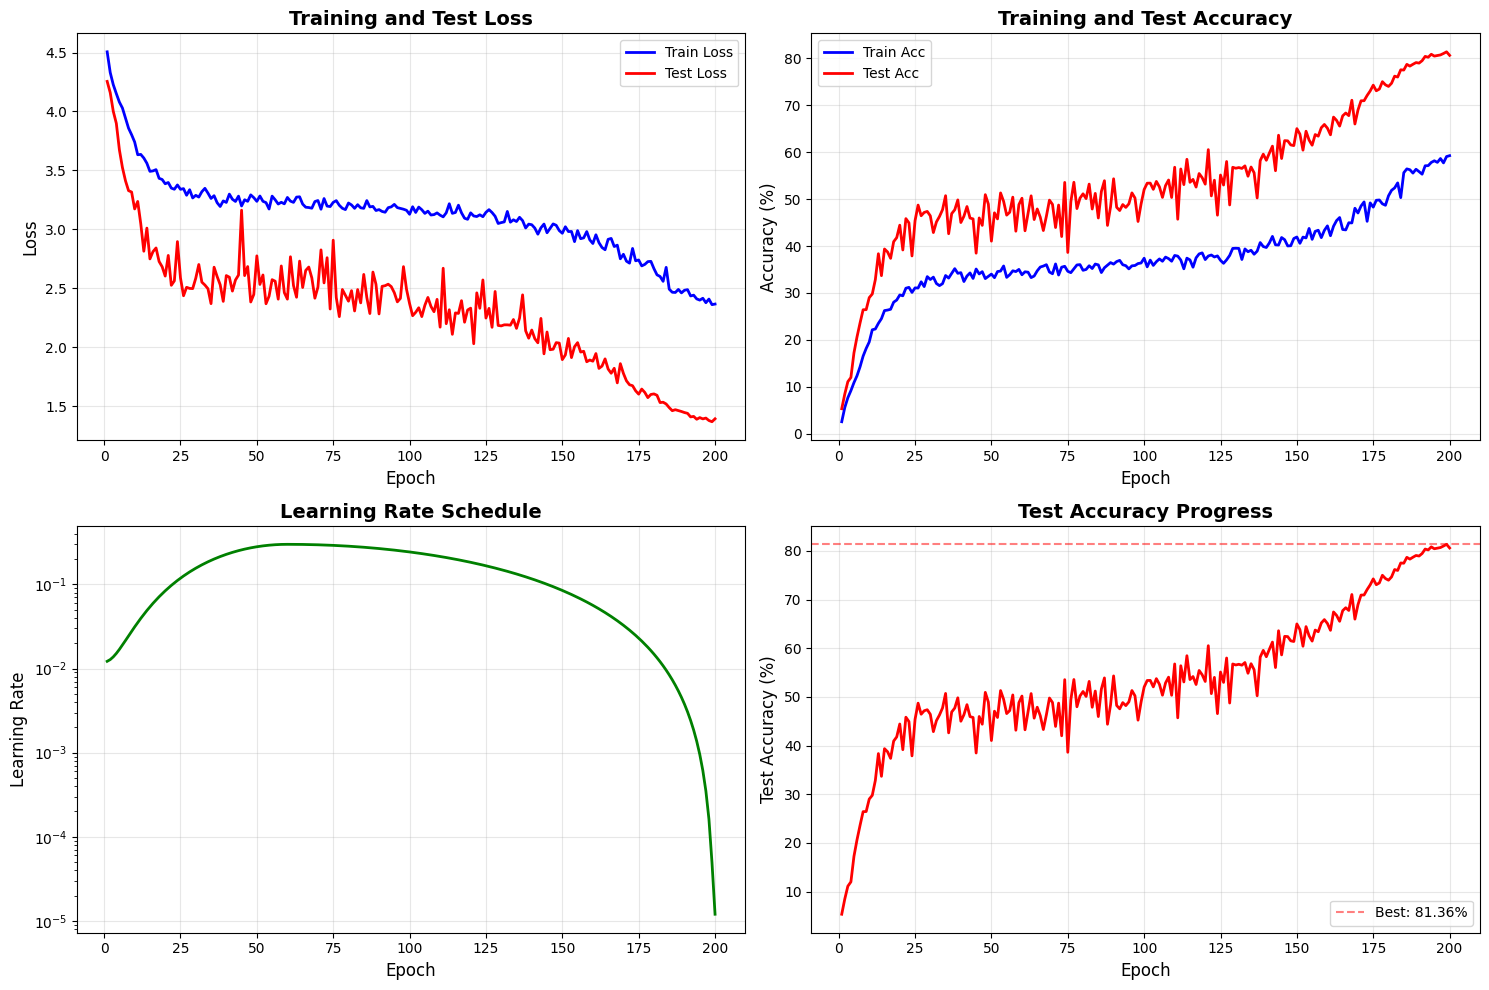

In [ ]:
plot_training_history(history)